In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import sklearn.datasets

import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

torch.set_default_dtype(torch.float32)

plt.rcParams['figure.dpi'] = 140
DEFAULT_X_RANGE = (-3.5, 3.5)
DEFAULT_Y_RANGE = (-2.5, 2.5)
DEFAULT_CMAP = colors.ListedColormap(["#377eb8", "#ff7f00"])
DEFAULT_NORM = colors.Normalize(vmin=0, vmax=1,)
DEFAULT_N_GRID = 100

### Generating the Two Moons / Circles Dataset

In [2]:
# Two Moons
def make_moon_training_data(sample_size=500):
    
    """Create two moon training dataset."""
    train_examples, train_labels = sklearn.datasets.make_moons(
      n_samples=2 * sample_size, noise=0.1)

    # Adjust data position slightly.
    train_examples[train_labels == 0] += [-0.1, 0.2]
    train_examples[train_labels == 1] += [0.1, -0.2]

    return train_examples, train_labels

def make_moon_testing_data(x_range=DEFAULT_X_RANGE, y_range=DEFAULT_Y_RANGE, n_grid=DEFAULT_N_GRID):
    """Create a mesh grid in 2D space."""
    # testing data (mesh grid over data space)
    x = np.linspace(x_range[0], x_range[1], n_grid)
    y = np.linspace(y_range[0], y_range[1], n_grid)
    xv, yv = np.meshgrid(x, y)
    return np.stack([xv.flatten(), yv.flatten()], axis=-1)

def make_moon_ood_data(sample_size=500, means=(2.5, -1.75), vars=(0.01, 0.01)):
    return np.random.multivariate_normal(means, cov=np.diag(vars), size=sample_size)

# Two Circles
def make_circles_training_data(sample_size=500):
    
    """Create two circles training dataset."""
    train_examples, train_labels = sklearn.datasets.make_circles(
      n_samples=2 * sample_size, noise=0.1)

    # Adjust data position slightly.
    train_examples[train_labels == 0] += [-1.2, - 0.7]
    train_examples[train_labels == 1] += [1.15, - 0.7]

    return train_examples, train_labels

def make_circles_testing_data(x_range=DEFAULT_X_RANGE, y_range=DEFAULT_Y_RANGE, n_grid=DEFAULT_N_GRID):
    """Create a mesh grid in 2D space."""
    # testing data (mesh grid over data space)
    x = np.linspace(x_range[0], x_range[1], n_grid)
    y = np.linspace(y_range[0], y_range[1], n_grid)
    xv, yv = np.meshgrid(x, y)
    return np.stack([xv.flatten(), yv.flatten()], axis=-1)

def make_circles_ood_data(sample_size=500, means=(-0.3, 1.36), vars=(0.01, 0.01)):
    return np.random.multivariate_normal(means, cov=np.diag(vars), size=sample_size)

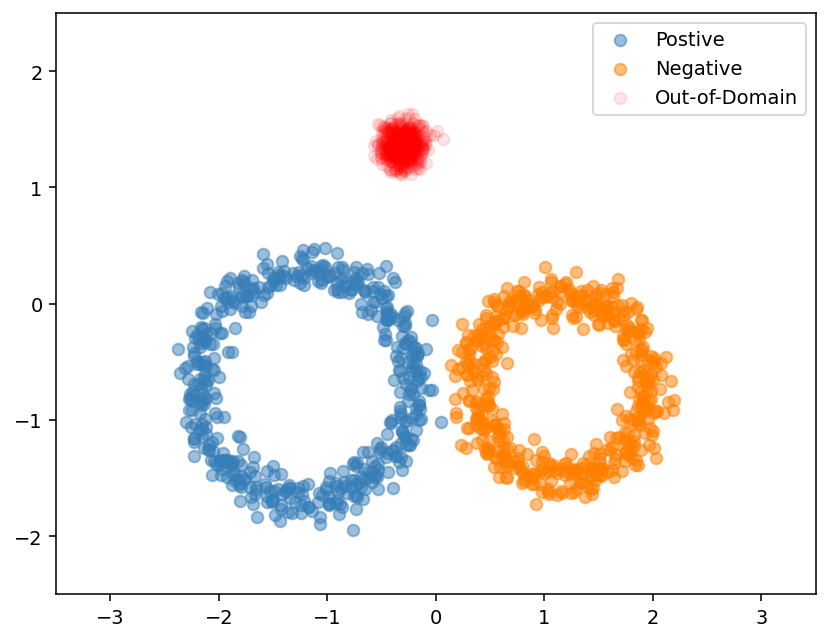

In [3]:
# Use false for Circles dataset
moon_dataset = False

# Load the Train, Test and OOD Dataset
if moon_dataset:
    train_examples, train_labels = make_moon_training_data(sample_size=500)
    test_examples = make_moon_testing_data()
    ood_examples = make_moon_ood_data(sample_size=500)
else:
    train_examples, train_labels = make_circles_training_data(sample_size=500)
    test_examples = make_circles_testing_data()
    ood_examples = make_circles_ood_data(sample_size=500)
    
# Visualize
pos_examples = train_examples[train_labels == 0]
neg_examples = train_examples[train_labels == 1]

plt.figure(figsize=(7, 5.5))

plt.scatter(pos_examples[:, 0], pos_examples[:, 1], c="#377eb8", alpha=0.5)
plt.scatter(neg_examples[:, 0], neg_examples[:, 1], c="#ff7f00", alpha=0.5)
plt.scatter(ood_examples[:, 0], ood_examples[:, 1], c="red", alpha=0.1)

plt.legend(["Postive", "Negative", "Out-of-Domain"])

plt.ylim(DEFAULT_Y_RANGE)
plt.xlim(DEFAULT_X_RANGE)

plt.show()

### Use GPU if available

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


### GP / DKL Classifier

In [5]:
import gpytorch

from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import UnwhitenedVariationalStrategy
from gpytorch.variational import VariationalStrategy

In [6]:
X_train = torch.from_numpy(train_examples).type(torch.float)
y_train = torch.from_numpy(train_labels).type(torch.float)

In [7]:
# GP Classifier
class GPclassifier(ApproximateGP):
    def __init__(self, train_x):
        variational_distribution = CholeskyVariationalDistribution(train_x.size(0))
        variational_strategy = VariationalStrategy(
            self, train_x, variational_distribution, learn_inducing_locations=True
        )
        super(GPclassifier, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred

# DKL
class DKL(ApproximateGP):
    def __init__(self, train_x):
        variational_distribution = CholeskyVariationalDistribution(train_x.size(0))
        variational_strategy = VariationalStrategy(
            self, train_x, variational_distribution, learn_inducing_locations=True
        )
        super(DKL, self).__init__(variational_strategy)
        
        self.feature_extractor = nn.Sequential(nn.Linear(2, 128),
                                 nn.ReLU(),
                                 nn.Linear(128, 128),
                                 nn.ReLU(),
                                 nn.Linear(128, 2))
        
        self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(-1., 1.)
        
        self.mean_module = gpytorch.means.ConstantMean()
        
        # Select the Kernel
        # self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RQKernel(ard_num_dims=2))
        # self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=0.5, ard_num_dims=2))
        # self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel(ard_num_dims=2))
        # self.covar_module = gpytorch.kernels.ScaleKernel(ArcKernel(gpytorch.kernels.MaternKernel(nu=2.5), ard_num_dims=2))
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=2)) 
        
    def forward(self, x):
        
        projected_x = self.feature_extractor(x)
        projected_x = self.scale_to_bounds(projected_x)
        
        mean_x = self.mean_module(projected_x)
        covar_x = self.covar_module(projected_x)
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred

In [8]:
# Set false for DKL
use_gp =  False

# Initialize model and likelihood
if use_gp:
    model = GPclassifier(X_train).to(device)
    likelihood = gpytorch.likelihoods.BernoulliLikelihood().to(device)
    training_iterations = 250
else:
    model = DKL(X_train).to(device)
    likelihood = gpytorch.likelihoods.BernoulliLikelihood().to(device)
    training_iterations = 250    
    
# Find optimal model hyperparameters
model.train()
likelihood.train()

X_train = X_train.to(device)
y_train = y_train.to(device)

In [9]:
import warnings
warnings.filterwarnings("ignore")

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# Loss for GPs - the marginal log likelihood
mll = gpytorch.mlls.VariationalELBO(likelihood, 
                                    model, 
                                    y_train.numel(), 
                                    combine_terms=False)

for i in range(training_iterations):
    # Empty gradients
    optimizer.zero_grad()
    
    # Get predictive output
    output = model(X_train)
    
    # Loss & Backprop
    log_lik, kl_div, log_prior = mll(output, y_train)
    loss = -(log_lik - kl_div + log_prior) 
    loss.backward()
    
    if i % 50 == 0:
        print(f"Iter: {i + 1}, Loss: {loss.item():.3f}")
        
    optimizer.step()

Iter: 1, Loss: 0.908
Iter: 51, Loss: 0.023
Iter: 101, Loss: 0.031
Iter: 151, Loss: 0.014
Iter: 201, Loss: 0.010


### Inference on OOD Inputs

In [10]:
test_examples = test_examples.astype(np.float32)
test_examples = torch.from_numpy(test_examples).to(device)

In [11]:
# Go into eval mode
model.eval()
likelihood.eval()

# Get classification predictions
with torch.no_grad():    
    observed_pred = likelihood(model(test_examples))

### Visualizing Uncertainty Surface

In [12]:
def plot_uncertainty_surface(test_uncertainty, ax, cmap=None):
    """Visualizes the 2D uncertainty surface.

    For simplicity, assume these objects already exist in the memory:

    test_examples: Array of test examples, shape (num_test, 2).
    train_labels: Array of train labels, shape (num_train, ).
    train_examples: Array of train examples, shape (num_train, 2).

    Arguments:
    test_uncertainty: Array of uncertainty scores, shape (num_test,).
    ax: A matplotlib Axes object that specifies a matplotlib figure.
    cmap: A matplotlib colormap object specifying the palette of the 
      predictive surface.

    Returns:
    pcm: A matplotlib PathCollection object that contains the palette 
      information of the uncertainty plot.
    """
    # Normalize uncertainty for better visualization.
    test_uncertainty = test_uncertainty / np.max(test_uncertainty)

    # Set view limits.
    ax.set_ylim(DEFAULT_Y_RANGE)
    ax.set_xlim(DEFAULT_X_RANGE)

    # Plot normalized uncertainty surface.
    pcm = ax.imshow(
      np.reshape(test_uncertainty, [DEFAULT_N_GRID, DEFAULT_N_GRID]), 
      cmap=cmap,
      origin="lower",
      extent=DEFAULT_X_RANGE + DEFAULT_Y_RANGE,
      vmin=DEFAULT_NORM.vmin,
      vmax=DEFAULT_NORM.vmax,
      interpolation='bicubic', 
      aspect='auto')

    # Plot training data.
    ax.scatter(train_examples[:, 0], train_examples[:, 1],
             c=train_labels, cmap=DEFAULT_CMAP, alpha=0.5)
    ax.scatter(ood_examples[:, 0], ood_examples[:, 1], c="red", alpha=0.1)

    return pcm

In [13]:
model_uncertainty = observed_pred.mean * (1 - observed_pred.mean)

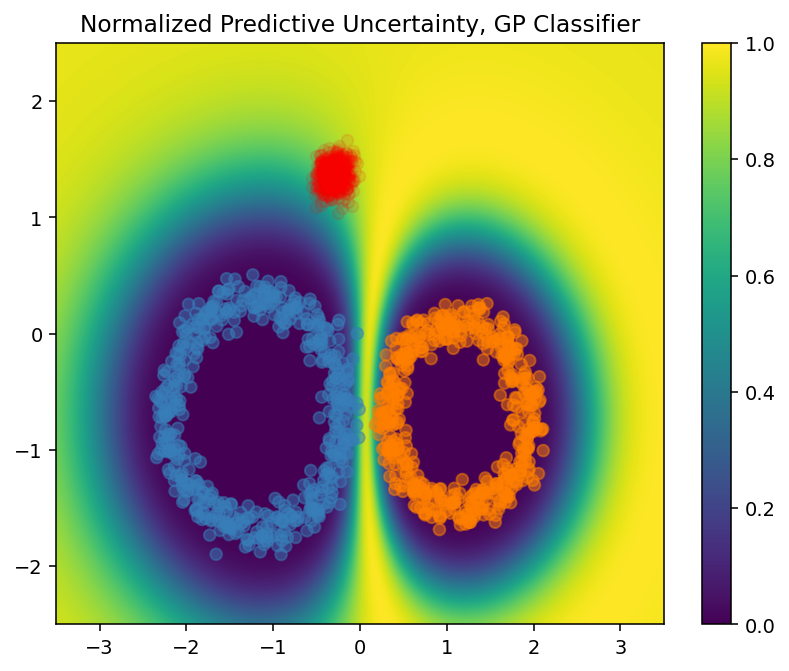

In [18]:
_, ax = plt.subplots(figsize=(7, 5.5))
pcm = plot_uncertainty_surface(model_uncertainty.cpu().numpy(), ax=ax)
plt.colorbar(pcm, ax=ax)
plt.title("Normalized Predictive Uncertainty, GP Classifier")
plt.show()

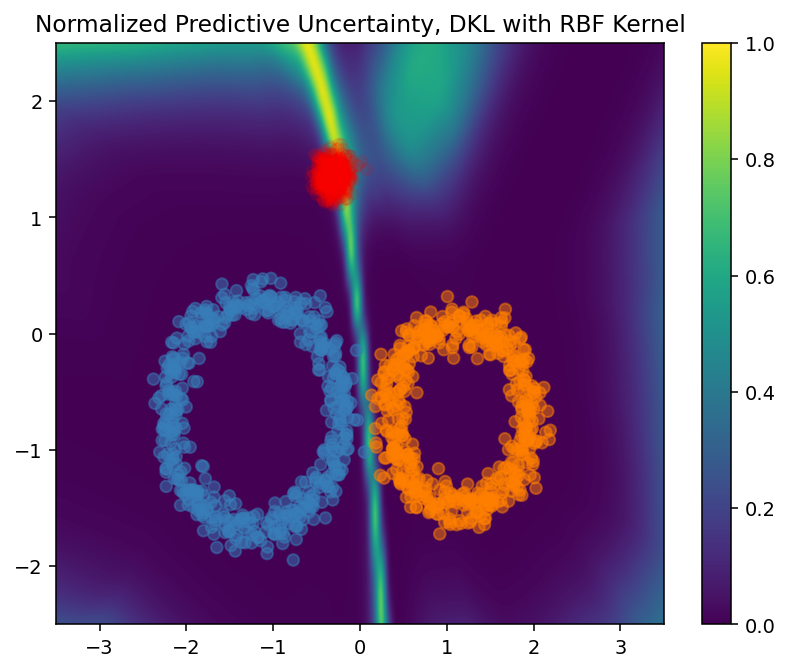

In [14]:
_, ax = plt.subplots(figsize=(7, 5.5))
pcm = plot_uncertainty_surface(model_uncertainty.cpu().numpy(), ax=ax)
plt.colorbar(pcm, ax=ax)
plt.title("Normalized Predictive Uncertainty, DKL with RBF Kernel")
plt.show()